# **Modelo de deteccion de estado de semaforos para ayudar a versonas invidentes**

###INTEGRANTES

Cesar Enrique Rojas Hernandez - 2191952

Santiago Andres Delgado Quiceno - 211799

Robayo Nieto Mariana - 2195092

In [ ]:
#@title Introduccion { display-mode: "form" }
from IPython.display import Image, display
url = "https://2.bp.blogspot.com/-Lz6hTiQT5LM/XCXD4kM7CqI/AAAAAAAACp4/\
gtenbm5odpQNPkaczgCJ8nMN8NJFF18iwCLcBGAs/s1600/jumilla-instalara-semaforos-para-invidentes.jpg"
display(Image(url=url))

El problema de autonomia con el que cuentan muchas perosnas invidentes al momento de estar fuera de sus casas es que se les hace dificil movilizarse por las calles debido a que los conductores no son concientes y en los pasos de sebra no suelen ceder el paso a las personas invidentes, al igual que es muy complicado saber el estado de los semaforos para pasar con mas seguridad, debido a esto se propone un modelo de inteligencia artificial que aprenda a detectar el estado del semaforo y indicar a la perosna el estado del semaforo

In [ ]:
#@title importar librerias { display-mode: "form" }
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import tensorflow as tf
from tensorflow import keras
from google.colab import files, drive
from tqdm.notebook import tqdm
print(tf.__version__)

2.12.0


In [ ]:
#@title **MONTAR EL DRIVE** { display-mode: "form" }
mi_direccion = ["IA-1-UIS/SFSemaforos Clasificación", "Inteligencia_Artificial/Proyecto/resultado", "IA-1-UIS/SFSemaforos Clasificación/data2"]
path = "/content/drive/My Drive/" + mi_direccion[2]
drive.mount('/content/drive', force_remount=True)
os.chdir(path)
print()
print(f"direccion actual: {os.getcwd()}")
print(f"Contenido: {os.listdir()}")

Mounted at /content/drive

direccion actual: /content/drive/My Drive/IA-1-UIS/SFSemaforos Clasificación/data2
Contenido: ['rojo', 'verde', 'imagen_superpuesta_semaforos_rojos.jpg', 'imagen_superpuesta_semaforos_verdes.jpg']


In [ ]:
#@title Listar los datos de entrenamiento { display-mode: "form" }
semaforos_rojos = [os.path.join('rojo', img) for img in os.listdir('rojo')]
semaforos_verdes = [os.path.join('verde', img) for img in os.listdir('verde')]

print(f"semaforos rojos: {len(semaforos_rojos)}, semaforos verdes: {len(semaforos_verdes)}")

semaforos rojos: 774, semaforos verdes: 874


# **Mostrar imagenes de ejemplo**

268 rojo/rojo (88).jpg


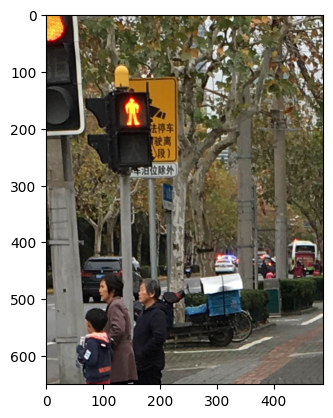

In [ ]:
# @title Imagenes de semaforos en rojo { display-mode: "form" }
index_red_image = random.randint(0, len(semaforos_rojos)-1)
img = Image.open(semaforos_rojos[index_red_image])
print(index_red_image, semaforos_rojos[index_red_image])
imgplot = plt.imshow(img)
plt.show()

263 verde/verde (485).jpg


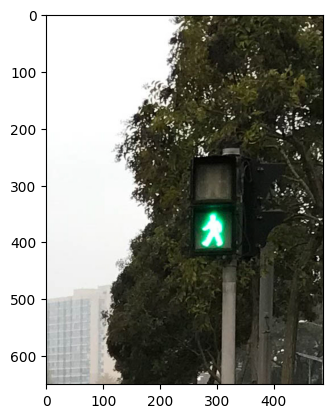

In [ ]:
# @title imagenes de semaforos en verde { display-mode: "form" }
index_green_image = random.randint(0, len(semaforos_verdes)-1)
img = Image.open(semaforos_verdes[index_green_image])
print(index_green_image, semaforos_verdes[index_green_image])
imgplot = plt.imshow(img)
plt.show()

# **Generar imagenes "superpuestas"**

In [ ]:
img = cv2.imread(semaforos_rojos[0]).shape
resize = (128,128)
alpha = 0.1

  0%|          | 0/774 [00:00<?, ?it/s]

774


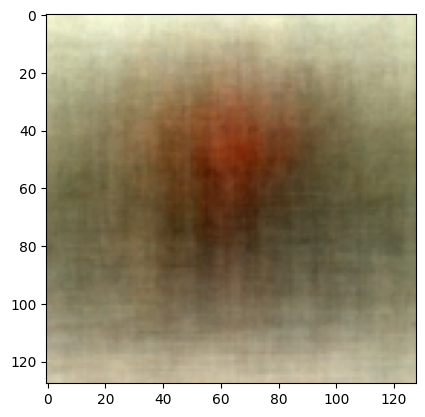

In [ ]:
# @title Imagen promedio de muestras de semaforos rojos { display-mode: "form" }
# Superponer las imagenes una encima de la otra con una opacidad del 0.1
red_images = []
average_red_img = 0

for i in tqdm(semaforos_rojos):
  img = Image.open(i)
  img = img.resize(resize, resample=Image.BICUBIC)
  img_array = np.array(img)[:, :, :3]
  average_red_img += alpha * img_array
  red_images.append(img_array)

a = 255 / (average_red_img.max() - average_red_img.min())
b = -a * average_red_img.min()
average_red_img = (a * average_red_img + b).astype(np.uint8)
plt.imshow(average_red_img)
print(len(red_images))


  0%|          | 0/791 [00:00<?, ?it/s]

791


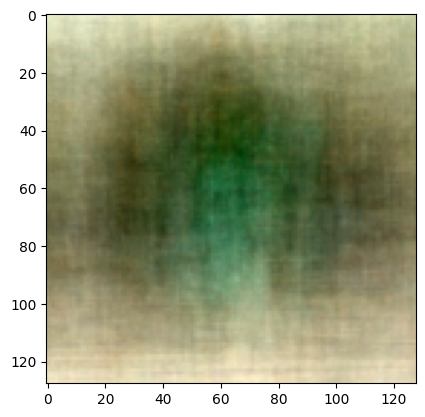

In [ ]:
from logging import exception
# @title Imagen promedio de muestras de semaforos verdes { display-mode: "form" }
green_images = []
average_green_img = 0

for i in tqdm(semaforos_verdes):
    img = Image.open(i)
    img = img.resize(resize, resample=Image.BICUBIC)
    img_array = np.array(img, dtype=np.float32)[:, :, :3]
    average_green_img += alpha * img_array
    green_images.append(img_array)

a = 255 / (average_green_img.max() - average_green_img.min())
b = -a * average_green_img.min()
average_green_img = (a * average_green_img + b).astype(np.uint8)

plt.imshow(average_green_img)
print(len(green_images))


# **Tratamiento de imagenes**

In [ ]:
# @title Normalizar y redimensionar { display-mode: "form" }
a_red_images = np.array(red_images)
a_green_images = np.array(green_images)
r = np.zeros(a_red_images.shape[0])
g = np.ones(a_green_images.shape[0])
y = np.concatenate((r, g), axis=0)

a_red_images = a_red_images.reshape(a_red_images.shape[0], -1)
a_red_images = a_red_images / 255.0

a_green_images = a_green_images.reshape(a_green_images.shape[0], -1)
a_green_images = a_green_images / 255.0

X = np.concatenate((a_red_images, a_green_images), axis=0)
a_green_images = None
a_red_images = None

In [ ]:
print(X.shape)
print(y.shape)

(1565, 49152)
(1565,)


# **Entrenamiento de estimadores**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import *

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# s = cross_val_score(model, X, y, cv=KFold(20, shuffle=True), scoring="accuracy")
# print ("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.588 (+/- 0.05398)


In [ ]:
# model = RandomForestClassifier(n_estimators=100, min_samples_split=2)
# model = DecisionTreeClassifier(min_samples_split= 5, min_samples_leaf= 1, max_features= 'sqrt', max_depth= 20)
# model = GaussianNB()

model = SVC(kernel= 'linear')

In [ ]:
model.fit(X_train, y_train)
print(f"Precisión del clasificador '{model.__class__.__name__}':")
predictions = model.predict(X_test)
print(classification_report(predictions, y_test))

Precisión del clasificador 'SVC':
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.68       166
         1.0       0.64      0.71      0.68       147

    accuracy                           0.68       313
   macro avg       0.68      0.68      0.68       313
weighted avg       0.68      0.68      0.68       313



**Precision**: La precisión mide la proporción de predicciones positivas que fueron realmente correctas en relación con todas las predicciones positivas realizadas por el modelo.

**Recall**: El recall, también conocido como sensibilidad o tasa de verdaderos positivos, mide la proporción de casos positivos que fueron correctamente identificados por el modelo en relación con todos los casos positivos reales.

**F1-score**: El F1-score es una medida que combina la precisión y el recall en un solo valor. Es útil cuando se desea tener en cuenta tanto la precisión como el recall al evaluar el rendimiento general del modelo.

**Support**: El soporte indica la cantidad de muestras en cada clase o categoría del problema de clasificación.

**Accuracy**: La exactitud es la proporción de predicciones totales (positivas y negativas) que fueron correctas. Es una métrica general del rendimiento del modelo.


# **Prueba de modelos**

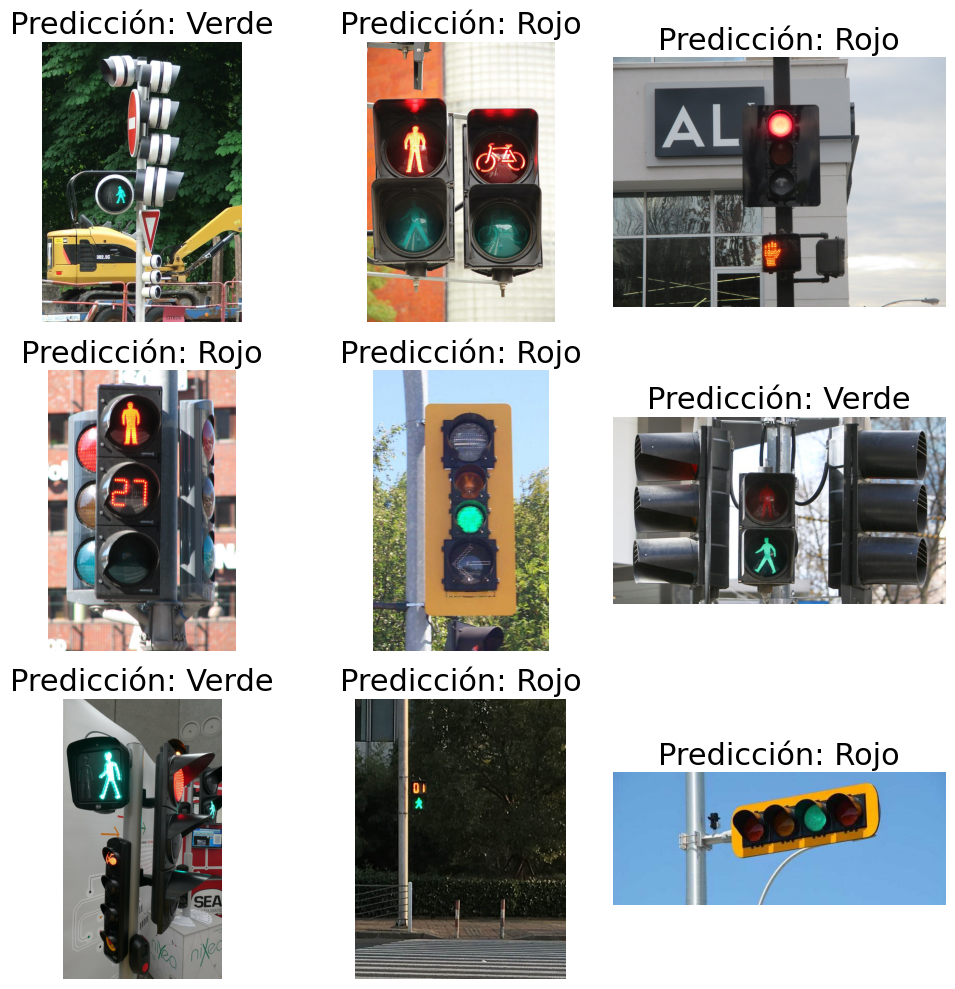

In [ ]:
predictions = model.predict(X_test2)

# Seleccionar algunas imágenes de prueba para visualizar
num_images = 3  # Número de imágenes para visualizar

# Obtener índices aleatorios de las imágenes de prueba
random_indices = np.random.choice(len(X_test2), size=num_images**2, replace=False)

# Visualizar las imágenes y las predicciones
fig, axes = plt.subplots(num_images, num_images, figsize=(10, 10))

for i, index in enumerate(random_indices):
    image = img_X_test[index]
    prediction = predictions[index]

    # Configurar el título de la imagen con el resultado de la predicción
    title = 'Predicción: Verde' if prediction > 0.5 else 'Predicción: Rojo'

    # Configurar el color del título según la precisión de la predicción

    # Mostrar la imagen y el título en el subplot correspondiente
    ax = axes[i // num_images, i % num_images]
    ax.imshow(image)
    ax.set_title(title, fontdict={"fontsize": 22})
    ax.axis('off')

# Ajustar el espaciado entre los subplots y mostrar la figura
plt.tight_layout()
plt.show()
